# 二項分布モデルの場合の最尤法とベイズ法の比較

* 黒木玄
* 2023-12-09
$
\newcommand\op{\operatorname}
$

最尤法では確かに「特定のパラメータ値(点)を求めることが目的」になるが, 通常は区間推定(信頼区間)と仮説検定との組み合わせで使われる. 点推定値だけを報告してはいけないことは統計学の常識の1つである.

点推定と信頼区間と仮説検定の組み合わせはP値函数という1つの函数からすべて導かれる(非常に残念なことにこの次事実に触れている入門的教科書が見当たらない).

そしてP値函数はベイズ統計における事前分布とほぼ同じ使われ方をする.

ベイズ統計における「特定のパラメータ値ではなく, パラメータ値の確率分布を求めることが目的」の最尤法での類似物は「特定のパラメータ値ではなく, パラメータ値のP値函数を求めることが目的」になる.

ベイズ統計における信用区間(HDPやETI)によって「幅による予測が可能」なことの最尤法での類似物は信頼区間によって「幅による予測が可能」になる. 

しかも, 統計モデルか単純で事前分布として平坦事前分布もしくはそれに近い事前分布を採用した場合には, ベイズ統計による「幅による予測」と最尤法による「幅による予測」は数値的にほぼ一致する場合が多い. 

例えば, 最小二乗法による線形回帰では, 回帰係数と残差の分散の対数についての平坦事前分布を採用すれば, ベイズ版と非ベイズ版での回帰係数の区間推定の結果は誤差無しにぴったり一致する.

このノートでは以上の事実を二項分布モデルの場合に実演して見せる. 二項分布モデルの場合には近似的な一致になる.

In [1]:
using Distributions
using Optim
using StatsPlots
default(fmt=:png, titlefontsize=10, guidefontsize=10, tickfontsize=6)

## 二項分布モデルの最尤法

当たりが出る確率が $p$ のルーレットを $n$ 回まわしたとき, $k$ 回当たりが出る確率は

$$
P(k|n,p) = \frac{n!}{k!(n-k)!} p^k(1-p)^{n-k}.
$$

「$n$ 回中当たりが $k$ 回」というデータの数値が得られたときの, 当たりが出る確率 $p$ の最尤推定値は

$$
\hat{p} = \frac{k}{n}
$$

になることを容易に示せる.  この場合には二項分布の正規分布近似を使った次のP値函数がよく使われている:

$$
\op{pvalue}(k|n,p) = 2\op{ccdf}(\op{Normal}(0,1), |z|), \quad
z = \frac{p - \hat{p}}{\sqrt{p(1-p)/n}}.
$$

ここで, $\op{ccdf}(\op{Normal}(0,1), x)$ は標準正規分布 $\op{Normal}(0,1)$ の補累積分布函数である:

$$
\op{ccdf}(\op{Normal}(0,1), x) = \int_x^\infty \frac{\exp(-t^2/2)}{\sqrt{2\pi}}\,dt.
$$

最尤推定値 $\hat{p}$ はP値函数から $p\mapsto \op{pvalue}(k|n,p)$ が最大値 $1$ になるパラメータ値 $p$ として再現される.

$100(1-\alpha)\%$ 信頼区間は $\op{pvalue}(k|n,p)\ge\alpha$ となるパラメータ値 $p$ 全体の集合として定義される.

## 二項分布モデル＋平坦事前分布のベイズ統計

当たりが出る確率 $p$ の事前分布として, 次の平坦事前分布を考える:

$$
\varphi(p) = 1 \quad (0\le p\le 1).
$$

「$n$ 回中当たりが $k$ 回」というデータの数値が得られたときの事後分布 $\varphi(p|k,n)$ はベータ分布 $\op{Beta}(k+1, n-k+1)$ になる:

$$
\varphi(p|k,n) = \frac{p^k(1-p)^{n-k}}{B(k+1, n-k+1} \quad (0\le p\le 1).
$$

これは尤度函数と定数倍の違いを除いて等しいでの, MAP推定値は最尤推定値に一致する.

$100(1-\alpha)\%$ 信用区間のHDI版(highest density interval版)は, 事後分布で測った確率が $1-\alpha$ になるパラメータ $p$ の最短の区間と定義される.

## 実装

In [2]:
# 以上の実装例

# P値函数と信頼区間

safediv(x, y) = x == 0 ? zero(x/y) : x/y

mle_binomial(k, n) = k/n

function pvalue_binomial_wilson(k, n, p)
    phat, se = mle_binomial(k, n), √(p * (1 - p) / n)
    z = safediv(phat - p, se)
    2ccdf(Normal(0,1), abs(z))
end

function confint_binomia_wilson(k, n, α=0.05)
    phat, z = k/n, quantile(Normal(), 1-α/2)
    a, b, c = 1+z^2/n, phat+z^2/(2n), phat^2
    sqrtD = √(b^2 - a*c)
    [(b - sqrtD)/a, (b + sqrtD)/a]
end

# 事後分布とHDI版の信用区間

function posterior_binomial(k, n; a=1, b=1)
    Beta(k+a, n-k+b)
end

function highest_density_interval(
        dist::ContinuousUnivariateDistribution, α = 0.05; alg = Brent())
    f(p) = quantile(dist, p + (1 - α)) - quantile(dist, p)
    o = optimize(f, 0, α, alg)
    p = o.minimizer
    quantile.(dist, [p, p + (1 - α)])
end

function hdi_posterior_binomial(k, n, α=0.05; a=1, b=1)
    post = posterior_binomial(k, n; a, b)
    highest_density_interval(post, α)
end

function map_binomial(k, n; a=1, b=1)
    (k+a-1)/(n+a+b-2)
end

# 以上を比較するためのプロット

r3(x) = round(x; sigdigits=3)

function plot_bin(; k=2, n=5, α=0.05, a=1, b=1)
    phat_mle = mle_binomial(k, n)
    ci_mle = confint_binomia_wilson(k, n, α)
    
    post = posterior_binomial(k, n; a, b)
    phat_map = map_binomial(k, n; a, b)
    ci_hdi = hdi_posterior_binomial(k, n, α; a, b)

    println("MLE point estimate, $(100(1-α))% confidence interval     = ",
        r3(phat_mle), ", ", r3.(ci_mle))
    println("MAP point estimate, $(100(1-α))% credible interval (HDI) = ",
        r3(phat_map), ", ", r3.(ci_hdi))
    println()

    c = 1
    P = plot()
    plot!(p -> pvalue_binomial_wilson(k, n, p), 0, 1; label="", c)
    scatter!([phat_mle], [pvalue_binomial_wilson(k, n, phat_mle)]; 
        label="point estimate", c=c+2, msc=:auto)
    plot!(ci_mle, fill(α, 2); label="$(100(1-α))% CI", c=c+4, lw=3)
    plot!(xtick = 0:0.05:1, ytick = 0:0.05:1)
    plot!(xguide="p", yguide="P-value")
    title!("P-value function for data k=$k, n=$n")
    
    c = 2
    Q = plot()
    plot!(post; label="", c)
    scatter!([phat_map], [pdf(post, phat_map)];
        label="point estimate", c=c+2, msc=:auto)
    plot!(ci_hdi, pdf.(post, ci_hdi); label="$(100(1-α))% CI (HDI)", c=c+4, lw=3)
    plot!(xtick = 0:0.05:1)
    plot!(xguide="p", yguide="probability density")
    title!("posterior density for data k=$k, n=$n and prior Beta($a, $b)")
    
    plot(P, Q; size=(600, 600), layout=(2,1))
end

plot_bin (generic function with 1 method)

## 平坦事前分布の場合

MLE point estimate, 95.0% confidence interval     = 0.333, [0.0968, 0.7]
MAP point estimate, 95.0% credible interval (HDI) = 0.333, [0.0805, 0.685]



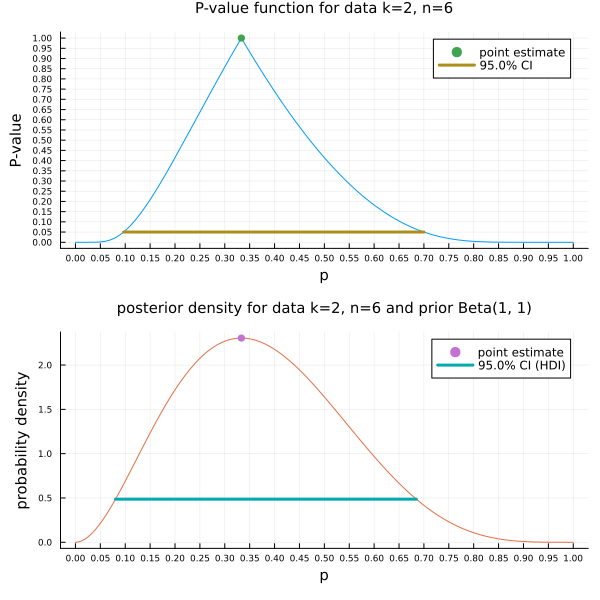

In [3]:
plot_bin(k=2, n=6)

MLE point estimate, 95.0% confidence interval     = 0.333, [0.227, 0.459]
MAP point estimate, 95.0% credible interval (HDI) = 0.333, [0.224, 0.456]



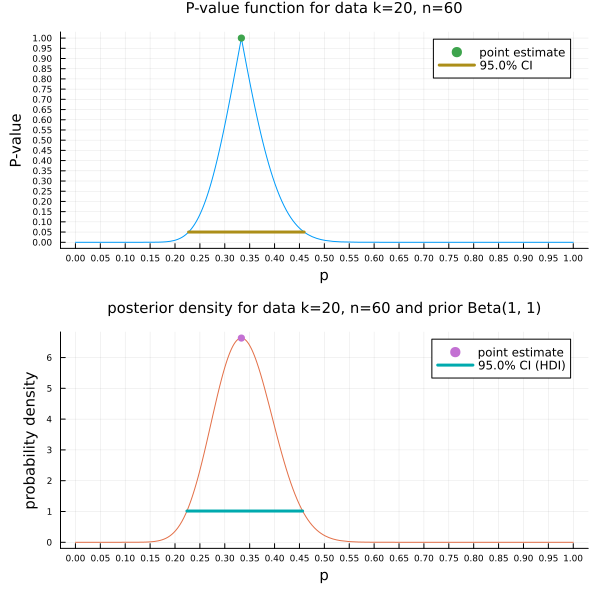

In [4]:
plot_bin(k=20, n=60)

MLE point estimate, 95.0% confidence interval     = 0.333, [0.297, 0.372]
MAP point estimate, 95.0% credible interval (HDI) = 0.333, [0.296, 0.372]



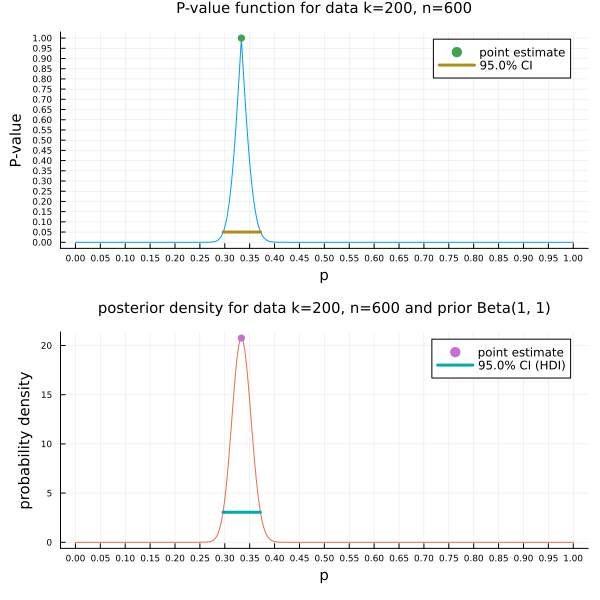

In [5]:
plot_bin(k=200, n=600)

## 偏った事前分布の場合

MLE point estimate, 95.0% confidence interval     = 0.333, [0.0968, 0.7]
MAP point estimate, 95.0% credible interval (HDI) = 0.571, [0.328, 0.792]



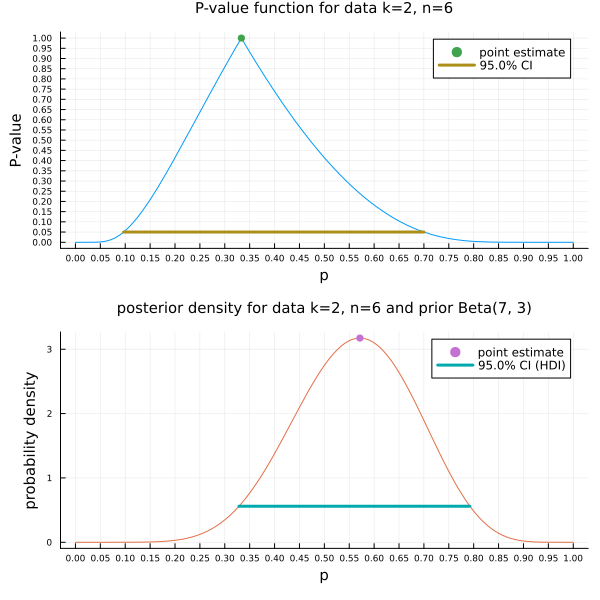

In [6]:
plot_bin(k=2, n=6, a=7, b=3)

MLE point estimate, 95.0% confidence interval     = 0.333, [0.227, 0.459]
MAP point estimate, 95.0% credible interval (HDI) = 0.382, [0.274, 0.499]



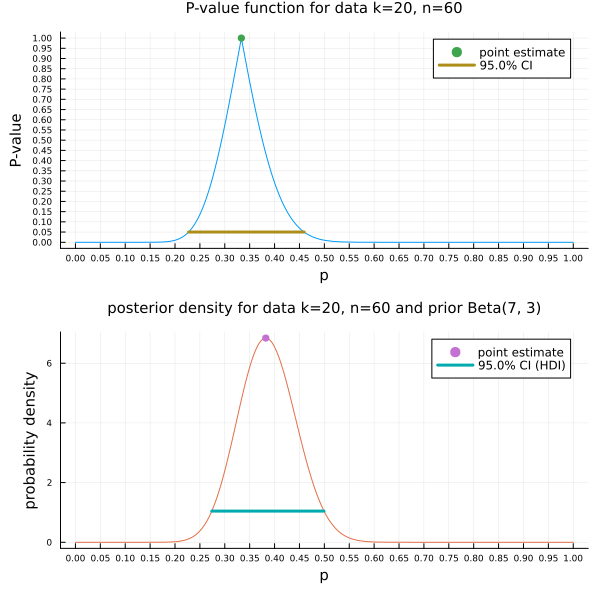

In [7]:
plot_bin(k=20, n=60, a=7, b=3)

MLE point estimate, 95.0% confidence interval     = 0.333, [0.297, 0.372]
MAP point estimate, 95.0% credible interval (HDI) = 0.339, [0.302, 0.377]



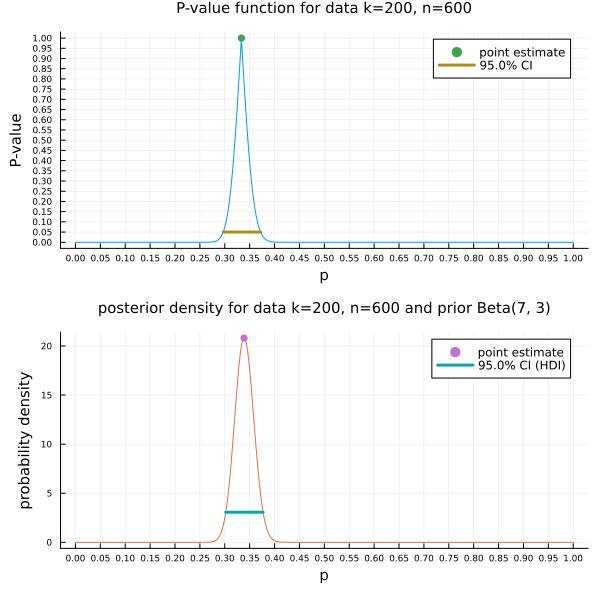

In [8]:
plot_bin(k=200, n=600, a=7, b=3)